<a href="https://colab.research.google.com/github/willyptrain/CAD-For-Mammogram-Scans/blob/master/cs_4774_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/drive/")

!unzip -q 'drive/My Drive/face_mask_detection.zip' 


Mounted at /content/drive/


In [2]:
import torchvision
import glob
import os
from bs4 import BeautifulSoup
import numpy as np
import shutil
import matplotlib.pyplot as plt
from collections import Counter
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset
from PIL import Image
import torch
import matplotlib
import cv2
import matplotlib.patches as patches
from torch.utils.data import SubsetRandomSampler

os.makedirs('train/images')
os.makedirs('train/annotations')
os.makedirs('test/images')
os.makedirs('test/annotations')


In [3]:


def load_train_split_paths(directory):
  img_paths = glob.iglob(directory)
  path_bases = []
  original_files = []
  for path in img_paths:
    # print(path, path.split("/")[1].rstrip(".png"))
    path_bases.append(path.split("/")[1].rstrip(".png"))


  # print('maksssksksss0' in path_bases)
  # path_bases = sorted(path_bases, key = lambda x: int(x.split("maksssksksss")[1]))
  # for val in path_bases:
  #   print(original_files.index(val), original_files[original_files.index(val)])
  # # print(int(x[0].split("maksssksksss")[1]))
  # print(path_bases)
  

  train_paths = path_bases[0:500]
  val_paths = path_bases[500:700]
  test_paths = path_bases[700:]

  train_paths += val_paths
  val_paths = []

  print("Training size:", len(train_paths))
  print("Validation size:", len(val_paths))
  print("Testing size:", len(test_paths))
  return train_paths, val_paths, test_paths

train_paths, val_paths, test_paths = load_train_split_paths("images/*")



Training size: 700
Validation size: 0
Testing size: 153


In [4]:


# shutil.rmtree('annotations/')
# shutil.rmtree('images/')
# shutil.rmtree('train/')
# shutil.rmtree('test/')
print("starting move")
for path in train_paths:
  img_path = os.path.join('images/', path+".png")
  annot_path = os.path.join('annotations/', path+".xml")
  shutil.move(img_path, 'train/images')
  shutil.move(annot_path, 'train/annotations')

print("ending train move, starting test")

for path in test_paths:
  img_path = os.path.join('images/', path+".png")
  annot_path = os.path.join('annotations/', path+".xml")
  shutil.move(img_path, 'test/images')
  shutil.move(annot_path, 'test/annotations')

print("finished moving")


starting move
ending train move, starting test
finished moving


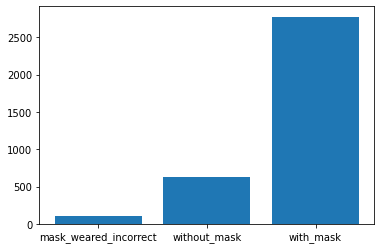

In [5]:
def read_annotations(base_dir, paths):
  label_mappings = {"with_mask": 0, "mask_weared_incorrect": 1, "without_mask":2}
  annotation_set = {}
  y = []
  y_labels = []
  y_boxes = []
  literal_labels = []
  for path in paths:
    xml_path = os.path.join(base_dir, path) + ".xml"
    with open(xml_path) as f:
      contents = f.read()
    xml_read = BeautifulSoup(contents, "xml")
    
    classes = []
    boxes = []

    truth_detections = xml_read.find_all("object")
    for obj in truth_detections:
      xmin = int(obj.find('xmin').text)
      xmax = int(obj.find('xmax').text)
      ymin = int(obj.find('ymin').text)
      ymax = int(obj.find('ymax').text)
      boxes.append([xmin, ymin, xmax, ymax])
      if(obj.find('name').text in label_mappings):
        classes.append(label_mappings[obj.find('name').text])
        literal_labels.append(obj.find('name').text)
      else: 
        literal_labels.append("N/A")
        classes.append(-1)

    classes = np.array(classes)
    boxes = np.array(boxes)
    y_boxes.append(boxes)
    y_labels.append(classes)
  

    annotation_set[path] = {
        'classes':classes, 
        'boxes':boxes
    }

    y.append([classes, boxes])
  
  y_boxes = np.array(y_boxes)
  y_labels = np.array(y_labels)
  return annotation_set, y_boxes, y_labels, literal_labels


train_annotation_set, y_train_boxes, y_train_labels, train_literal_labels = read_annotations('train/annotations/', train_paths)
test_annotation_set, y_test_boxes, y_test_labels, test_literal_labels = read_annotations('test/annotations/', test_paths)



frequency_unique_labels = Counter(train_literal_labels)
frequency_unique_labels = sorted(frequency_unique_labels.items(), key=lambda x: x[1])
plt.bar([i[0] for i in frequency_unique_labels], [i[1] for i in frequency_unique_labels])
plt.show()



tensor([[[0.9490, 0.9529, 0.9569,  ..., 0.4784, 0.4784, 0.4902],
         [0.9490, 0.9569, 0.9569,  ..., 0.4824, 0.4824, 0.4824],
         [0.9608, 0.9608, 0.9569,  ..., 0.4667, 0.4863, 0.4824],
         ...,
         [0.8314, 0.8314, 0.8275,  ..., 0.3765, 0.3451, 0.3373],
         [0.8314, 0.8353, 0.8431,  ..., 0.3647, 0.3451, 0.3490],
         [0.8431, 0.8510, 0.8588,  ..., 0.3529, 0.3412, 0.3412]],

        [[0.9725, 0.9725, 0.9647,  ..., 0.5373, 0.5412, 0.5451],
         [0.9686, 0.9686, 0.9647,  ..., 0.5294, 0.5373, 0.5412],
         [0.9686, 0.9725, 0.9647,  ..., 0.5255, 0.5294, 0.5373],
         ...,
         [0.8235, 0.8275, 0.8275,  ..., 0.3529, 0.3451, 0.3412],
         [0.8314, 0.8314, 0.8392,  ..., 0.3490, 0.3412, 0.3294],
         [0.8392, 0.8471, 0.8392,  ..., 0.3490, 0.3373, 0.3333]],

        [[0.9804, 0.9843, 0.9804,  ..., 0.5804, 0.5882, 0.5922],
         [0.9804, 0.9843, 0.9804,  ..., 0.5843, 0.5882, 0.5922],
         [0.9843, 0.9843, 0.9765,  ..., 0.5843, 0.5765, 0.

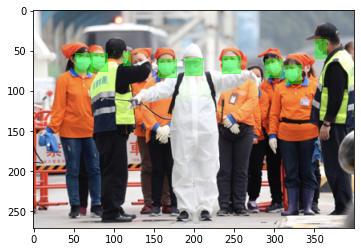

In [19]:

class FaceMaskDataset(Dataset):
  def __init__(self, base_dir, annotation_set, labels, images,transform=None):
    self.base_dir = base_dir
    self.annotation_set = annotation_set #boxes and classes dictionary from read_annotations()
    self.transform = transform #in case data needs to be transformed to torch tensor before fed into model
    self.labels = [i for i in glob.iglob(os.path.join(base_dir,'annotations/*'))]
    self.images = [i for i in glob.iglob(os.path.join(base_dir,'images/*'))]

  def __getitem__(self, idx):
    if(torch.is_tensor(idx)):
      idx = idx.tolist()

    image_path = os.path.join(os.path.join(self.base_dir,'images'), 'maksssksksss'+str(idx)+".png")
    image = Image.open(image_path).convert("RGB")

    # print("yo from inside", self.annotation_set.keys())
    boxes = self.annotation_set['maksssksksss'+str(idx)]['boxes']

    labels = self.annotation_set['maksssksksss'+str(idx)]['classes']
    sample = {
        'image_id': torch.tensor([idx]),#self.transform([image_path]),
        'boxes':self.transform(boxes)[0],
        'labels': torch.as_tensor(np.array(labels))
    }

    # sample = self.transform(image)

    return self.transform(image), sample



  def __len__(self):
    return len(self.labels)



tensor_transform = transforms.Compose([
    transforms.ToTensor(),
]) #transforms data to work with torchvision model


train_mask_dataset = FaceMaskDataset(base_dir='train/',annotation_set=train_annotation_set, labels=y_train_labels, images=train_paths ,transform=tensor_transform)
test_mask_dataset = FaceMaskDataset(base_dir='test/',annotation_set=test_annotation_set, labels=y_test_labels, images=test_paths, transform=tensor_transform)

test = train_mask_dataset[3]

def plot_box(sample):
  # print(sample)
  img = sample[0]
  print(img)
  boxes = sample[1]['boxes']
  labels = sample[1]['labels']
  fig,ax = plt.subplots(1)
  ax.imshow(np.transpose(img,(1,2,0)))
  for i, box in enumerate(boxes):
    xmin, ymin, xmax, ymax = box
    color = (1,0,0,0.4) if labels[i] == 2 else (0,1,0,0.4)
    rect = matplotlib.patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,edgecolor=color,facecolor=color)
    ax.add_patch(rect)

  plt.show()  

plot_box(test)


In [20]:

train_size = 700
print(list(os.listdir('train/images/')))
train_indices = [int(path.lstrip("maksssksksss").rstrip(".png")) for path in list(os.listdir('train/images/'))[:-1]]
print(len(train_indices), train_indices)
train_sampler = SubsetRandomSampler(train_indices)


print(list(os.listdir('test/images/')))
test_indices = [int(path.lstrip("maksssksksss").rstrip(".png")) for path in list(os.listdir('test/images/'))[:-1]]
print(len(test_indices), test_indices)
test_sampler = SubsetRandomSampler(test_indices)



['maksssksksss850.png', 'maksssksksss501.png', 'maksssksksss717.png', 'maksssksksss797.png', 'maksssksksss470.png', 'maksssksksss95.png', 'maksssksksss653.png', 'maksssksksss812.png', 'maksssksksss499.png', 'maksssksksss440.png', 'maksssksksss330.png', 'maksssksksss107.png', 'maksssksksss441.png', 'maksssksksss747.png', 'maksssksksss185.png', 'maksssksksss386.png', 'maksssksksss31.png', 'maksssksksss290.png', 'maksssksksss153.png', 'maksssksksss423.png', 'maksssksksss544.png', 'maksssksksss21.png', 'maksssksksss780.png', 'maksssksksss640.png', 'maksssksksss674.png', 'maksssksksss738.png', 'maksssksksss40.png', 'maksssksksss243.png', 'maksssksksss176.png', 'maksssksksss320.png', 'maksssksksss623.png', 'maksssksksss808.png', 'maksssksksss276.png', 'maksssksksss446.png', 'maksssksksss743.png', 'maksssksksss111.png', 'maksssksksss505.png', 'maksssksksss418.png', 'maksssksksss589.png', 'maksssksksss399.png', 'maksssksksss555.png', 'maksssksksss706.png', 'maksssksksss380.png', 'maksssksksss8

In [35]:
#With help from: https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True) #loads the Faster R-CNN model trained on the COCO dataset
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, 3) #number of classes = 3 : with_mask, without_mask, mask_not_worn_corrected

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu') #loads the gpu if available to speed up training




#SOURCE: 
def collate_fn(batch):
    return tuple(zip(*batch)) #batches loaded and zipped to be unpacked as img, annotations

train_dataLoader = torch.utils.data.DataLoader(
        train_mask_dataset, batch_size=16, num_workers=4, sampler=train_sampler, collate_fn=collate_fn)
test_dataLoader = torch.utils.data.DataLoader(
        test_mask_dataset, batch_size=1, shuffle=False, num_workers=4, sampler=test_sampler, collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# for i in train_mask_dataset:
# print(i)


# print(len(train_mask_dataset))



for imgs,annotations in train_dataLoader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    break

In [64]:
num_epochs = 10
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.0001,
#                                 momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(params, lr=0.000001)

len_dataloader = len(train_dataLoader) #equal to size of dataset / batch size !

print("Length of data loader: ", len_dataloader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in train_dataLoader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        # print(annotations[0])
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        # for val_imgs, val_annotations in test_dataLoader:
        #   val_imgs = list(img.to(device) for img in val_imgs)
        #   val_annotations = [{k: v.to(device) for k, v in t.items()} for t in val_annotations]
        #   val_loss_dict = model([val_imgs[0]], [val_annotations[0]])
        #   val_losses = sum(loss for loss in val_loss_dict.values())        
        #   break
        # print(i, "Validation Loss:", val_losses)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
        # print(i)
    print(epoch_loss)




Length of data loader:  44
tensor(3.7494, device='cuda:0', grad_fn=<AddBackward0>)
tensor(7.1823, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.7690, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.5165, device='cuda:0', grad_fn=<AddBackward0>)
tensor(5.0714, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.5716, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.9350, device='cuda:0', grad_fn=<AddBackward0>)
tensor(4.9207, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.6078, device='cuda:0', grad_fn=<AddBackward0>)
tensor(3.0133, device='cuda:0', grad_fn=<AddBackward0>)


0.9441786408424377
0.12193986028432846
0.08529503643512726
0.07112059742212296
0.05861686170101166
0.05730617791414261


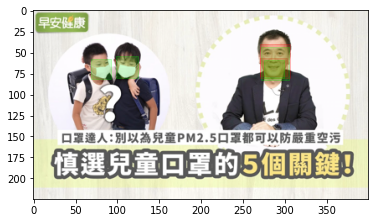

In [84]:
def plot_image(img_tensor, annotation):
    
    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))
    
    for i, box in enumerate(annotation["boxes"]):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        # c = annotation["labels"][i]
        # print(c)
        # rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        print(float(annotation["scores"][i]))
        if(float(annotation["scores"][i]) > 0.0):          
          color = (1,0,0,0.1) if annotation["labels"][i] == 2 else (0,1,0,0.1)
          rect = matplotlib.patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,edgecolor=color,facecolor=color)
          ax.add_patch(rect)

          # Add the patch to the Axes
          ax.add_patch(rect)

    plt.show()


for test_imgs, test_annotations in test_dataLoader:
        test_imgs = list(img.to(device) for img in test_imgs)
        test_annotations = [{k: v.to(device) for k, v in t.items()} for t in test_annotations]
        break




model.eval()
# test = Image.open('one_mask_no_mask.JPG').convert("RGB")#.rotate(270)
# test = tensor_transform(test)

test = test_imgs[0]
test = test.to(device)
preds = model([test])
preds


plot_image(test, preds[0])